In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_file

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
data_date_and_time = '20190504034237'
data_files = get_data_files(data_date_and_time)
noise_files = [preceding_noise_file(f) for f in data_files]
cfg = CounterConfig(data_files, noise_files)
ckv = GetCkv(cfg)

Now let's simulate an event with given shower parameters.

In [3]:
pars = [500.,2.e6,np.deg2rad(40.),np.deg2rad(315.), 450., -660.,-25.25,0,70,80.]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_event(ev)
print(ev)

Event(E=1538461538461538.5, Xmax=500.0, Nmax=2000000.0, zenith=0.6981317007977318, azimuth=5.497787143782138, corex=450.0, corey=-660.0, corez=-25.25, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

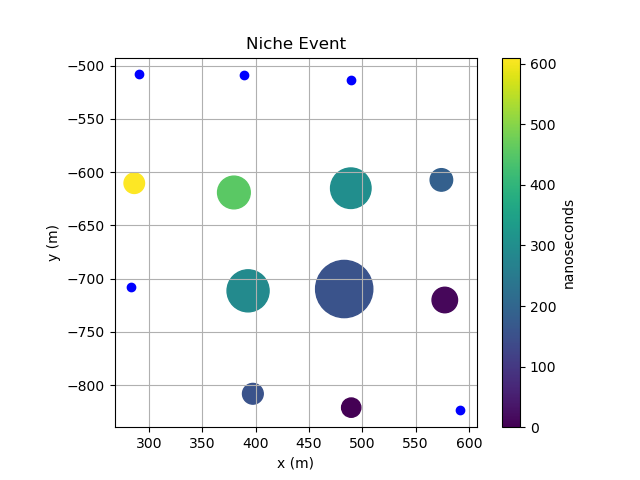

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
pf

20240312162830.000025480
curie dirac feynman meitner newton rossi rubin rutherford yukawa 
nx =  0.4545 ny = -0.4802 z0 =   2.4
  +/- 0.0003   +/- 0.0004   +/-  0.0
  ( 8.72e-08  1.13e-08 -9.49e-07)
  ( 1.13e-08  1.34e-07  3.48e-07)
  (-9.49e-07  3.48e-07  1.85e-04)
th =  0.7224 ph =  5.4703

In [6]:
guess = make_guess(ty, pf,cfg)
# for i,p in enumerate(guess):
#     guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=500.0, limits=(400.0, 800.0), error=50.0, fixed=False)
FitParam(name='nmax', value=100000.0, limits=(10000.0, 100000000.0), error=100000.0, fixed=False)
FitParam(name='zenith', value=0.7224312715665449, limits=(0.0, 0.8224312715665448), error=0.017453292519943295, fixed=False)
FitParam(name='azimuth', value=5.47030754760208, limits=(5.3703075476020805, 5.57030754760208), error=0.017453292519943295, fixed=False)
FitParam(name='corex', value=449.4578850833982, limits=(379.5, 489.2), error=5.0, fixed=False)
FitParam(name='corey', value=-677.5624976610865, limits=(-711.4, -615.1), error=5.0, fixed=False)
FitParam(name='corez', value=-25.25, limits=(-25.25, -25.25), error=1.0, fixed=True)
FitParam(name='x0', value=0.0, limits=(0, 0), error=1, fixed=True)
FitParam(name='lambda', value=70.0, limits=(70.0, 70.0), error=1, fixed=True)
FitParam(name='t_offset', value=0.0, limits=(-150.0, 150.0), error=10.0, fixed=False)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [7]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

Now we can begin the fit procedure, starting by fitting the peaktimes for the shower angles.

Now with a good estimate for the angles, we can fit the pulse widths to estimate xmax.

In [8]:
pt = PeakTimes(real_nfits, BasicParams, cfg)
pt.target_parameters = ['zenith','azimuth']
m = init_minuit(pt, guess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.967 (χ²/ndof = 0.6)      │              Nfcn = 41               │
│ EDM = 0.178 (Goal: 0.1)          │           time = 10.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    500    │    50     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │   0.1e6   │   0.1e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 694.7e-3  │  0.4e-3   │            │            │    0    │0.822431 │       │
│ 3 │ azimuth  │  5.50362  │  0.00033  │            │            │ 5.37031 │ 5.57031 │       │
│ 4 │ corex    │    449    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.3   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -150   │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [9]:
tpguess = update_guess(m)
pw = PulseWidth(real_nfits, BasicParams, cfg)
pw.target_parameters = ['xmax']
m = init_minuit(pw, tpguess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 26.64 (χ²/ndof = 3.3)      │               Nfcn = 9               │
│ EDM = 0.19 (Goal: 0.1)           │            time = 3.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    500    │    29     │            │            │   400   │   800   │       │
│ 1 │ nmax     │   0.1e6   │   0.1e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 694.7e-3  │  0.4e-3   │            │            │    0    │0.822431 │  yes  │
│ 3 │ azimuth  │  5.50362  │  0.00033  │            │            │ 5.37031 │ 5.57031 │  yes  │
│ 4 │ corex    │    449    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.3   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -150   │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with a good estimate for log(xmax), we can fit the integrated pulse areas for nmax.

In [10]:
xmaxguess = update_guess(m)
pa = PulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['nmax']
m = init_minuit(pa, xmaxguess)
m.simplex(ncall=20)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 270.6 (χ²/ndof = 33.8)     │              Nfcn = 21               │
│ EDM = 0.0185 (Goal: 0.1)         │            time = 8.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    500    │    29     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │  1.71e6   │  0.06e6   │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 694.7e-3  │  0.4e-3   │            │            │    0    │0.822431 │  yes  │
│ 3 │ azimuth  │  5.50362  │  0.00033  │            │            │ 5.37031 │ 5.57031 │  yes  │
│ 4 │ corex    │    449    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.3   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -150   │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with these values in the ballpark, we can simultaneously minimize both the shower profile and core position by fitting the normalized pulse areas.

In [11]:
nmaxguess = update_guess(m)
pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['xmax','nmax','corex','corey']
m = init_minuit(pa, nmaxguess)
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.16 (χ²/ndof = 2.4)      │              Nfcn = 123              │
│ EDM = 0.0794 (Goal: 0.1)         │           time = 48.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    508    │     9     │            │            │   400   │   800   │       │
│ 1 │ nmax     │  1.89e6   │  0.09e6   │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 694.7e-3  │  0.4e-3   │            │            │    0    │0.822431 │  yes  │
│ 3 │ azimuth  │  5.50362  │  0.00033  │            │            │ 5.37031 │ 5.57031 │  yes  │
│ 4 │ corex    │   449.6   │    0.6    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -659.6   │    1.1    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.3   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │     0     │    10     │            │            │  -150   │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now that we're reasonably close to the minimum, we can zero in on it by freeing all the parameters simultaneously.

In [12]:
guess = update_guess(m)
at = AllTunka(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 238.8 (χ²/ndof = 6.8)      │              Nfcn = 77               │
│ EDM = 0.00649 (Goal: 0.0002)     │           time = 31.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    508    │     9     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │  1.89e6   │  0.09e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │ 694.7e-3  │  0.4e-3   │            │            │    0    │0.822431 │  yes  │
│ 3 │ azimuth  │  5.50362  │  0.00033  │            │            │ 5.37031 │ 5.57031 │  yes  │
│ 4 │ corex    │   449.6   │    0.6    │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │  -659.6   │    1.1    │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.3   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │  81.3670  │  0.0008   │            │            │  -150   │   150   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │        0        0        0        0        0        0        0        0        0        0 │
│     nmax │        0        0        0        0        0        0        0        0        0        0 │
│   zenith │        0        0        0        0        0        0        0        0        0        0 │
│  azimuth │        0        0        0        0        0        0        0        0        0        0 │
│    corex │        0        0        0        0        0        0        0        0        0        0 │
│    corey │        0        0        0        0        0        0        0        0        0        0 │
│    corez │        0        0        0        0        0        0        0        0        0        0 │
│       x0 │        0        0        0        0        0        0        0        0        0        0 │
│   lambda │        0        0        0        0        0        0        0        0        0        0 │
│ t_offset │        0        0        0        0        0        0        0        0        0 5.87e-07 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
guess = update_guess(m)
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)


In [14]:
m.tol=.1
m.fixed = True
m.fixed['xmax'] = False
m.fixed['nmax'] = False
m.fixed['zenith'] = False
m.fixed['azimuth'] = False
m.fixed['corex'] = False
m.fixed['corey'] = False
m.fixed['t_offset'] = False
# m.scan()
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 149.9 (χ²/ndof = 0.9)      │              Nfcn = 268              │
│ EDM = 0.235 (Goal: 0.1)          │           time = 85.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │   511.0   │    1.2    │            │            │   400   │   800   │       │
│ 1 │ nmax     │  1.890e6  │  0.014e6  │            │            │  10000  │  1e+08  │       │
│ 2 │ zenith   │ 698.7e-3  │  0.1e-3   │            │            │    0    │0.822431 │       │
│ 3 │ azimuth  │  5.49821  │  0.00016  │            │            │ 5.37031 │ 5.57031 │       │
│ 4 │ corex    │  449.56   │   0.05    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -659.57  │   0.05    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.3   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │ 81.36801  │  0.00006  │            │            │  -150   │   150   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [15]:
# m.limits['xmax'] = (m.params['xmax'].value-20.,m.params['xmax'].value+20.)
# m.limits['nmax'] = (m.params['nmax'].value-2.e5,m.params['nmax'].value+2.e5)
# m.limits['zenith'] = (m.params['zenith'].value-5.e-2,m.params['zenith'].value+5.e-2)
# m.limits['azimuth'] = (m.params['azimuth'].value-5.e-2,m.params['azimuth'].value+5.e-2)
# m.limits['corex'] = (m.params['corex'].value-5.,m.params['corex'].value+5.)
# m.limits['corey'] = (m.params['corey'].value-5.,m.params['corey'].value+5.)
# m.limits['t_offset'] = (m.params['t_offset'].value-5.,m.params['t_offset'].value+5.)
# m.fixed = True
# m.fixed['xmax'] = False
# m.fixed['nmax'] = False
# m.fixed['zenith'] = False
# m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.tol=1

In [16]:
# for par in guess:
#     m.errors[par.name] = par.error

In [21]:
fitpars = [p.value for p in m.params]
fit_ev = BasicParams.get_event(fitpars)
print(fit_ev)

Event(E=1453615489305209.8, Xmax=510.9980410351339, Nmax=1889700.1360967727, zenith=0.6987000683476601, azimuth=5.498209500966259, corex=449.5610870150843, corey=-659.5654197777126, corez=-25.25, X0=0.0, Lambda=70.0)


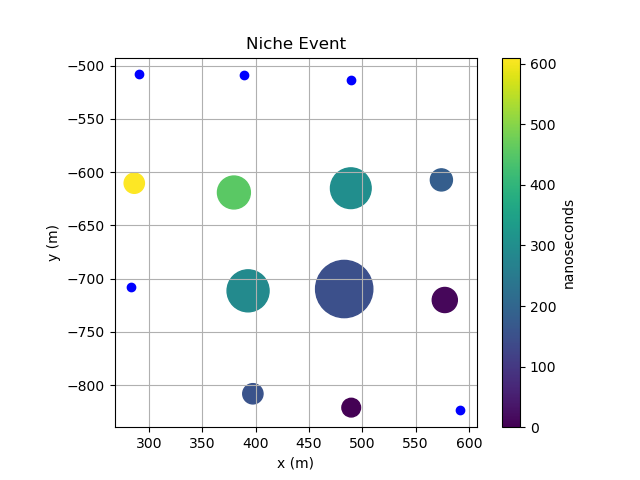

In [18]:
fit_nfits = pe.gen_nfits_from_event(fit_ev)
plot_event(tyro(fit_nfits))

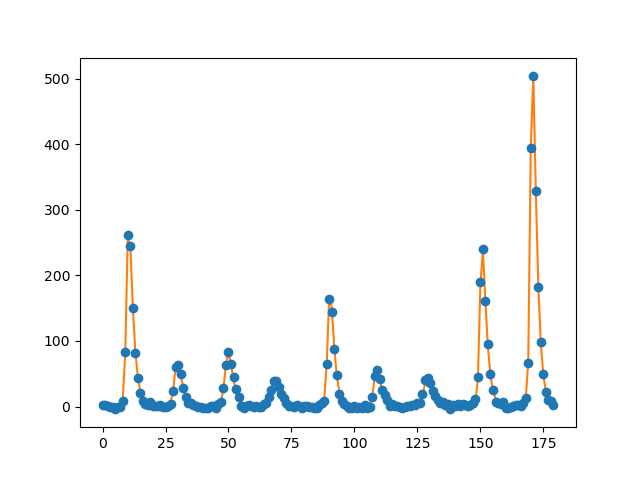

In [22]:
# at = AllTunka(real_nfits, BasicParams, cfg)
plt.figure()
plt.errorbar(np.arange(len(at.real_values)),at.real_values,yerr=at.error, fmt="o")
plt.plot(at.get_output(fitpars))

In [20]:
pars[-1] = fitpars[-1]
at.chi2(pars)/m.ndof

0.879092371712425